In [79]:
# dataframes
import pandas as pd
# numpy
import numpy as np
# plots
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import seaborn as sns
sns.set(font = "serif", style = "whitegrid", palette = "deep", font_scale = 0.75)
# ml models
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition  import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
# poly regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
# smoothing spline
from pygam import LinearGAM, s
from functools import reduce
# decision tree
from sklearn.tree import DecisionTreeRegressor

Let's do some preliminary analysis.

### sales
1. dimensions of the dataset;
2. data cleaning 	
	1. remove the empty columns and rows;
	2. check for null columns (each entry is `NaN`) / check for null rows;
	3. check types;
	4. `date`:
		- check range;
	5. `is_open`:
		- check is composed by `YES` and `NO` only;
		- edit the exeptions; 
	6. `sales_amount`: 
		- impose `if is_open == "NO" then sales_amount = 0` (and fix exeptions);
		- check if all values are non-negative (NO!);
		- edit negatives and `NaN`;

### market
1. dimensions of the dataset;
2. data cleaning 	
	1. remove the empty columns and rows;
	2. check for null columns (each entry is `NaN`) / check for null rows;
	3. check types;
	4. `id`:
		- unique identifier;
	5. `market_type`:
		- check is composed by correct labels;
	6. `squere_feet`: 
		- check positive; 
	5. `market_type`:
      	- solve `NaN` values;
	6. `avg_customer`: 
		- check positive (and correct);
		- set integer;
	7. `competitor_distance`: 
        - check positive;
	8. `has_promotions`:
		- check is composed by `YES` and `NO` only;

# sales

In [80]:
sales = pd.read_csv("data/sales.csv")
display(sales)

,market_id,date,is_open,sales_amount,
0,XC14,31/12/2022,YES,55727.34,NaN
1,WG25,31/12/2022,YES,12984.10,NaN
2,UX72,31/12/2022,YES,13046.56,NaN
3,EE84,31/12/2022,YES,60916.76,NaN
4,RF54,31/12/2022,YES,12376.42,NaN
...,...,...,...,...,...
523944,ZM74,01/01/2021,YES,21553.84,NaN
523945,WW60,01/01/2021,YES,56371.18,NaN
523946,LU14,01/01/2021,YES,24107.19,NaN
523947,HY57,01/01/2021,YES,12257.38,NaN


## 1

dimensions of the dataset

In [81]:
n_rows_sales = sales.shape[0]
n_cols_sales = sales.shape[1]
print("the number of rows is " + str(n_rows_sales) + " while the number of columns is " + str(n_cols_sales))

the number of rows is 523949 while the number of columns is 5


## 2

### 2.1

In [82]:
# remove empty colums
sales = sales.dropna(axis = 1, how = "all")
n_cols_sales = sales.shape[1]

# remove empty rows
sales = sales.dropna(axis = 0, how = "all")
n_rows_sales = sales.shape[0]
	
display(sales)

,market_id,date,is_open,sales_amount
0,XC14,31/12/2022,YES,55727.34
1,WG25,31/12/2022,YES,12984.10
2,UX72,31/12/2022,YES,13046.56
3,EE84,31/12/2022,YES,60916.76
4,RF54,31/12/2022,YES,12376.42
...,...,...,...,...
523944,ZM74,01/01/2021,YES,21553.84
523945,WW60,01/01/2021,YES,56371.18
523946,LU14,01/01/2021,YES,24107.19
523947,HY57,01/01/2021,YES,12257.38


### 2.2

check for NaN

In [83]:
n_nan = sales.isnull().sum().sum()
print("the total number of NaN is " + str(n_nan) + "\n")

print("the number of NaN in each column of sales is:")
for index in range(0, n_cols_sales):
	col = sales.iloc[:, index]
	n_nan_col = col.isnull().sum().sum()
	print("- " + sales.columns[index] + " = " + str(n_nan_col))

the total number of NaN is 14

the number of NaN in each column of sales is:
- market_id = 0
- date = 0
- is_open = 0
- sales_amount = 14


(commento) siccome i NaN sono solo in sales_amount bisogna capire come trattarli

### 2.3


check types

In [84]:
sales.dtypes

market_id        object
date             object
is_open          object
sales_amount    float64
dtype: object

### 2.4

check range of date

In [85]:
sales["date"] = pd.to_datetime(sales["date"], format = "%d/%m/%Y")
start_date = "01/01/2021"
end_date = "31/12/2022"

# boolean panda's series: True if the date is acceptable (inside the range), False otherwise
check_date_range = sales["date"].between(start_date, end_date)

n_date_out_of_range = n_rows_sales - check_date_range.sum()
print("the number of dates out of range is " + str(n_date_out_of_range))

the number of dates out of range is 0


### 2.5

check is_open is compesed only by yes and no

In [86]:
# boolean panda's series: True if is_open is acceptable ("YES" or "NO"), False otherwise
check_is_open = sales[~sales["is_open"].isin(["YES", "NO"])].index
print("the rows with no YES or NO in is_open are: " + str(list(check_is_open)))

display(sales.loc[check_is_open, :])

the rows with no YES or NO in is_open are: [49154]


,market_id,date,is_open,sales_amount
49154,BT51,2022-10-14,YESS,25220.48


(commento)

In [87]:
sales.loc[check_is_open[0], "is_open"] = "YES"

### 2.6

controlliamo che i NO abbiano sales_amount uguale a 0 e li correggiamo

In [88]:
# sales dataframe restricted to the condition is_open == "NO" with non-acceptable sales_amounts (!= 0)
sales_amount_no_error = sales[(sales["is_open"] == "NO") & (sales["sales_amount"] != 0)]
print("indexes where is_open is NO and sales_amount is not 0: " + str(list(sales_amount_no_error.index)))
sales.loc[sales_amount_no_error.index, "sales_amount"] = 0

indexes where is_open is NO and sales_amount is not 0: [753]


In [89]:
# sales dataframe restricted to the condition sales_amounts < 0
sales_amount_negative = sales[sales["sales_amount"] < 0]
sales_amount_negative

,market_id,date,is_open,sales_amount
47528,XC14,2022-10-16,YES,-999999.0
48150,XC14,2022-10-15,YES,-999999.0
48772,XC14,2022-10-14,YES,-999999.0
49394,XC14,2022-10-13,YES,-999999.0
50016,XC14,2022-10-12,YES,-999999.0
50638,XC14,2022-10-11,YES,-999999.0


trattiamo i dati negativi e NaN allo stesso modo: sostituiamo il valore con la media dei sales_amount dello stesso market <br>
(commento: altra opzione sarebbe mettere media sullo stesso giorno con market dello stesso tipo nello stessa nazione)

correcting errors: we iterate over the non-acceptable rows of the sales dataframe, subsituting the wrong sales_amounts with the previously computed mean

In [90]:
# sales dataframe restricted to the rows with non-acceptable sales_amounts (NaN or negative values)
sales_amount_error = sales[sales["sales_amount"].isnull() | (sales["sales_amount"] < 0)]
display(sales_amount_error)

# dataframe containing the market_id's and their correspondent mean sales_amount
mean_sales_amount = (sales[(sales["sales_amount"] > 0)].groupby("market_id"))["sales_amount"].mean()

# correcting errors
for index, row in (sales.loc[sales_amount_error.index]).iterrows():
	sales.loc[index, "sales_amount"] = mean_sales_amount[row["market_id"]]
# portion of the dataframe corrected
sales.loc[sales_amount_error.index]

,market_id,date,is_open,sales_amount
98,OG21,2022-12-31,YES,NaN
47528,XC14,2022-10-16,YES,-999999.0
48150,XC14,2022-10-15,YES,-999999.0
48772,XC14,2022-10-14,YES,-999999.0
49394,XC14,2022-10-13,YES,-999999.0
50016,XC14,2022-10-12,YES,-999999.0
50638,XC14,2022-10-11,YES,-999999.0
174088,UF73,2022-04-12,YES,NaN
223239,BY57,2022-02-05,YES,NaN
509998,NL22,2021-01-19,YES,NaN


,market_id,date,is_open,sales_amount
98,OG21,2022-12-31,YES,62768.8625279642
47528,XC14,2022-10-16,YES,60603.9004000000
48150,XC14,2022-10-15,YES,60603.9004000000
48772,XC14,2022-10-14,YES,60603.9004000000
49394,XC14,2022-10-13,YES,60603.9004000000
50016,XC14,2022-10-12,YES,60603.9004000000
50638,XC14,2022-10-11,YES,60603.9004000000
174088,UF73,2022-04-12,YES,12005.3310135135
223239,BY57,2022-02-05,YES,12628.2223217247
509998,NL22,2021-01-19,YES,12017.3499174917


# market

In [91]:
market = pd.read_csv("data/market.csv")
display(market)

,id,country,Unnamed: 2,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,XC14,SPAIN,NaN,HYPER,11135,773.0,515,YES
1,WG25,FRANCE,NaN,MINI,1402,252.0,522,YES
2,UX72,FRANCE,NaN,MINI,1452,265.0,15939,YES
3,EE84,SPAIN,NaN,HYPER,15259,874.0,754,YES
4,RF54,FRANCE,NaN,MINI,2497,191.0,34007,YES
...,...,...,...,...,...,...,...,...
745,ZM74,ITALY,NaN,SUPER,5778,356.0,4424,YES
746,WW60,FRANCE,NaN,HYPER,10923,907.0,41359,YES
747,LU14,ITALY,NaN,SUPER,5742,397.0,2841,YES
748,HY57,ITALY,NaN,MINI,2495,228.0,3848,YES


## 1

dimensions of the dataset

In [92]:
n_rows_market = market.shape[0]
n_cols_market = market.shape[1]
print("the number of rows is " + str(n_rows_market) + " while the number of columns is " + str(n_cols_market))

the number of rows is 750 while the number of columns is 8


## 2

### 2.1

In [93]:
# remove empty colums
market = market.dropna(axis = 1, how = "all")
n_cols_market = market.shape[1]

# remove empty rows
market = market.dropna(axis = 0, how = "all")
n_rows_market = market.shape[0]
	
display(market)

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,XC14,SPAIN,HYPER,11135,773.0,515,YES
1,WG25,FRANCE,MINI,1402,252.0,522,YES
2,UX72,FRANCE,MINI,1452,265.0,15939,YES
3,EE84,SPAIN,HYPER,15259,874.0,754,YES
4,RF54,FRANCE,MINI,2497,191.0,34007,YES
...,...,...,...,...,...,...,...
745,ZM74,ITALY,SUPER,5778,356.0,4424,YES
746,WW60,FRANCE,HYPER,10923,907.0,41359,YES
747,LU14,ITALY,SUPER,5742,397.0,2841,YES
748,HY57,ITALY,MINI,2495,228.0,3848,YES


### 2.2

check for NaN

In [94]:
n_nan = market.isnull().sum().sum()
print("the total number of NaN is " + str(n_nan) + "\n")

print("the number of NaN in each column of market is:")
for index in range(0, n_cols_market):
	col = market.iloc[:, index]
	n_nan_col = col.isnull().sum().sum()
	print("- " + market.columns[index] + " = " + str(n_nan_col))

the total number of NaN is 3

the number of NaN in each column of market is:
- id = 0
- country = 0
- market_type = 2
- square_feet = 0
- avg_customers = 1
- competitor_distance = 0
- has_promotions = 0


### 2.3

In [95]:
market.dtypes

id                      object
country                 object
market_type             object
square_feet              int64
avg_customers          float64
competitor_distance      int64
has_promotions          object
dtype: object

c'è un problema: avg_customers è float, invece noi lo si vuole int. Gli altri tipi vanno bene

### 2.4

In [96]:
print("the market id's are unique:", len(market) == len(pd.unique(market["id"])))

the market id's are unique: True


### 2.5

check market_type is compesed only by correct labels

In [97]:
# boolean panda's series: True if market_type is acceptable ("MINI", "SUPER" or "HYPER"), False otherwise
check_market_type = market[~market["market_type"].isin(["MINI", "SUPER", "HYPER"])].index
print("the rows with non correct labels are: " + str(list(check_market_type)))

display(market.loc[check_market_type, :])

the rows with non correct labels are: [90, 225]


,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
90,RU30,SPAIN,NaN,14305,637.0,1701,YES
225,KB10,ITALY,NaN,1520,150.0,479,YES


### 2.6

In [98]:
# boolean panda's series: True if square_feet is positive, False otherwise
check_square_feet = market[market["square_feet"] <= 0].index
print("the rows with negative square_feet are: " + str(list(check_square_feet)))

the rows with negative square_feet are: []


### 2.7

In [99]:
# market without uncorrect market_type 
market_correct = market.iloc[~market.index.isin(check_market_type)]

# dataframe containing the country, the market_type and their correspondent mean square_feet
mean_sqfeet_bycountry = (market_correct.groupby(["country", "market_type"]))["square_feet"].mean()
display(pd.DataFrame(mean_sqfeet_bycountry))

square_feet
country market_type                  
FRANCE  HYPER        12153.2258064516
        MINI          1998.4027777778
        SUPER         6035.2857142857
ITALY   HYPER        12052.1724137931
        MINI          2054.5267857143
        SUPER         6067.6551724138
SPAIN   HYPER        12063.7741935484
        MINI          1978.3670886076
        SUPER         6079.6060606061

tra le nazioni le medie degli square_feet non sono particolarmente diverse (per market_type)

correcting errors: we iterate over the non-acceptable rows of the market dataframe, subsituting the NaN values with the market type corresponding with the closest (in terms of square_feet) market_type in the same country

In [100]:
# correcting errors
for index, row in market.loc[check_market_type, :].iterrows():
	# panda's series with the square_feet means with respect to market_type in the country row["country"]
	mean_sqfeet_country = mean_sqfeet_bycountry[row["country"]]
	# closest square_feet value within the previous pandas series
	closest_sqfeet = min(mean_sqfeet_country, key = lambda x: abs(row["square_feet"] - x))
	# corresponding market_type
	closest_market_type = (mean_sqfeet_country[mean_sqfeet_country == closest_sqfeet]).index[0]
	# assigning the market_type
	market.loc[index, "market_type"] = closest_market_type

# corrected rows
display(market.loc[check_market_type, :])

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
90,RU30,SPAIN,HYPER,14305,637.0,1701,YES
225,KB10,ITALY,MINI,1520,150.0,479,YES


abbiamo mostrato con un loop come modificare i dati errati sebbene fossero solo 2, in quanto in contesti generici sarebbero potuti essere decine o centinaia i valori mancanti

### 2.8

In [101]:
# boolean panda's series: True if avg_customers is acceptable (not NaN or negative), False otherwise
check_avg_customers = market[market["avg_customers"].isnull() | (market["avg_customers"] < 0)].index
print("the rows with non acceptable values are: " + str(list(check_avg_customers)))

display(market.loc[check_avg_customers, :])

the rows with non acceptable values are: [69, 626]


,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
69,IP89,SPAIN,HYPER,15560,-9999.0,6281,YES
626,OD40,ITALY,HYPER,14157,NaN,3519,YES


(stessa roba di prima, non necessita commenti)

In [102]:
market_correct = market.iloc[~market.index.isin(check_avg_customers)]
mean_avgcust_bycountry = (market_correct.groupby(["country", "market_type"]))["avg_customers"].mean()
display(pd.DataFrame(mean_avgcust_bycountry))

for index, row in market.loc[check_avg_customers, :].iterrows():
	market.loc[index, "avg_customers"] = mean_avgcust_bycountry[row["country"]][row["market_type"]]

display(market.loc[check_avg_customers, :])

avg_customers
country market_type                
FRANCE  HYPER        688.2580645161
        MINI         210.5277777778
        SUPER        401.3968253968
ITALY   HYPER        733.7857142857
        MINI         208.6460176991
        SUPER        401.2931034483
SPAIN   HYPER        763.4838709677
        MINI         214.3291139241
        SUPER        405.3333333333

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
69,IP89,SPAIN,HYPER,15560,763.4838709677,6281,YES
626,OD40,ITALY,HYPER,14157,733.7857142857,3519,YES


tra le nazioni le medie degli avg_customers non sono particolarmente diverse (per market_type)

In [103]:
market["avg_customers"] = market["avg_customers"].round().astype('int')
display(market.loc[check_avg_customers, :])

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
69,IP89,SPAIN,HYPER,15560,763,6281,YES
626,OD40,ITALY,HYPER,14157,734,3519,YES


### 2.9

In [104]:
# boolean panda's series: True if competitor_distance is positive, False otherwise
check_competitor_distance = market[market["competitor_distance"] <= 0].index
print("the rows with negative competitor_distance are: " + str(list(check_square_feet)))

the rows with negative competitor_distance are: []


### 2.10

In [105]:
# boolean panda's series: True if has_promotions is acceptable ("YES" or "NO"), False otherwise
check_has_promotions = market[~market["has_promotions"].isin(["YES", "NO"])].index
print("the rows with non correct values are: " + str(list(check_has_promotions)))

# display(market.loc[check_has_promotions, :])

the rows with non correct values are: []


# dataset

## build dataset

collapse temporal information of sales

In [106]:
sales["is_open"] = sales["is_open"].map({"YES": 1, "NO": 0})
is_open = sales.groupby("market_id")["is_open"].mean().reset_index()
sales_amount = sales[sales["is_open"] == 1].groupby("market_id")["sales_amount"].mean().reset_index()
sales = pd.merge(is_open, sales_amount, on = "market_id")
display(sales)

,market_id,is_open,sales_amount
0,AA39,0.8273972603,12609.5795198675
1,AA82,0.8205128205,26573.8142187500
2,AB90,0.8301369863,26124.2837685950
3,AC71,0.8205128205,11856.3265178571
4,AD13,0.8246575342,12392.5510963455
...,...,...,...
745,ZX46,0.8301369863,12570.5495049505
746,ZX76,0.8205128205,12375.2464732143
747,ZY62,0.8273972603,26404.8513079470
748,ZZ11,0.8186813187,12542.2565771812


merge datasets

In [107]:
merged_df = pd.merge(sales, market, left_on = "market_id", right_on = "id", how = "left").drop(["market_id", "id"], axis = 1)
merged_df

,is_open,sales_amount,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,0.8273972603,12609.5795198675,FRANCE,MINI,2437,248,58,YES
1,0.8205128205,26573.8142187500,FRANCE,SUPER,6403,493,300,YES
2,0.8301369863,26124.2837685950,FRANCE,SUPER,7544,340,1598,YES
3,0.8205128205,11856.3265178571,SPAIN,MINI,1940,165,2068,YES
4,0.8246575342,12392.5510963455,FRANCE,MINI,1486,166,750,YES
...,...,...,...,...,...,...,...,...
745,0.8301369863,12570.5495049505,FRANCE,MINI,1691,272,1843,YES
746,0.8205128205,12375.2464732143,FRANCE,MINI,1462,159,547,YES
747,0.8273972603,26404.8513079470,FRANCE,SUPER,5946,488,2743,YES
748,0.8186813187,12542.2565771812,FRANCE,MINI,1413,239,1920,YES


## data_visualization

### boxplots

boxplots of quantitative variables

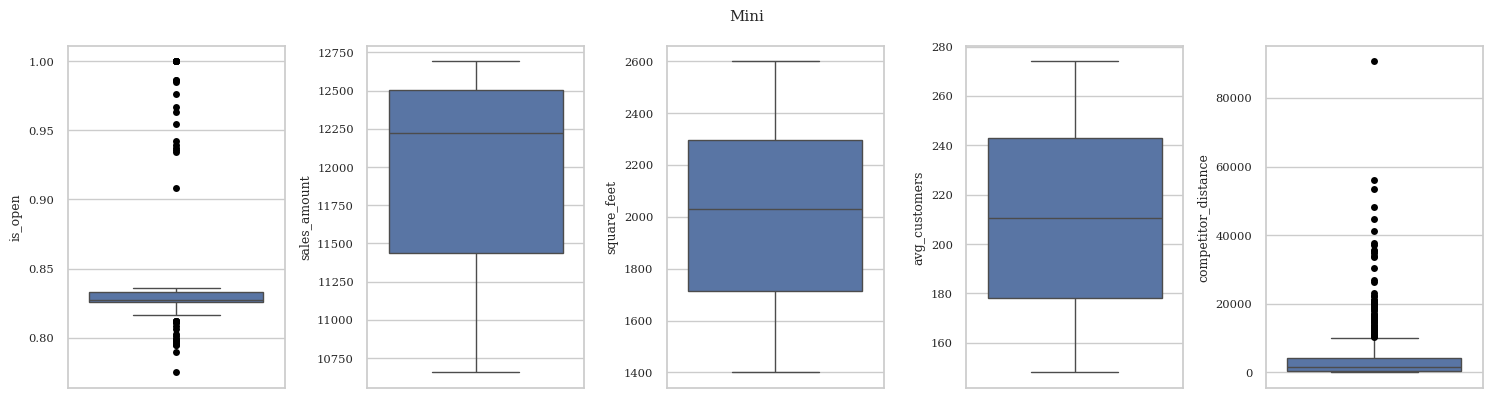

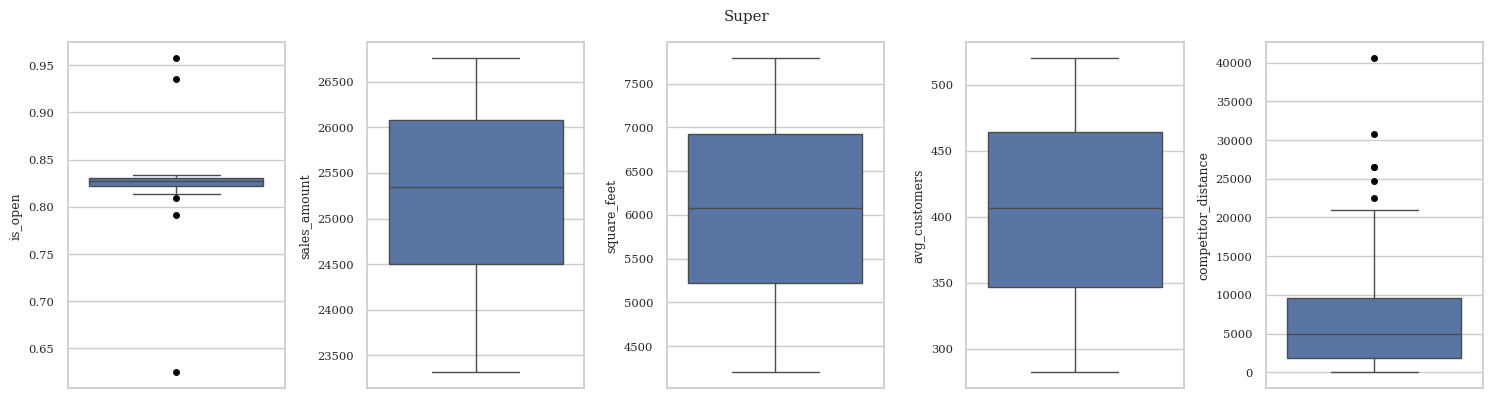

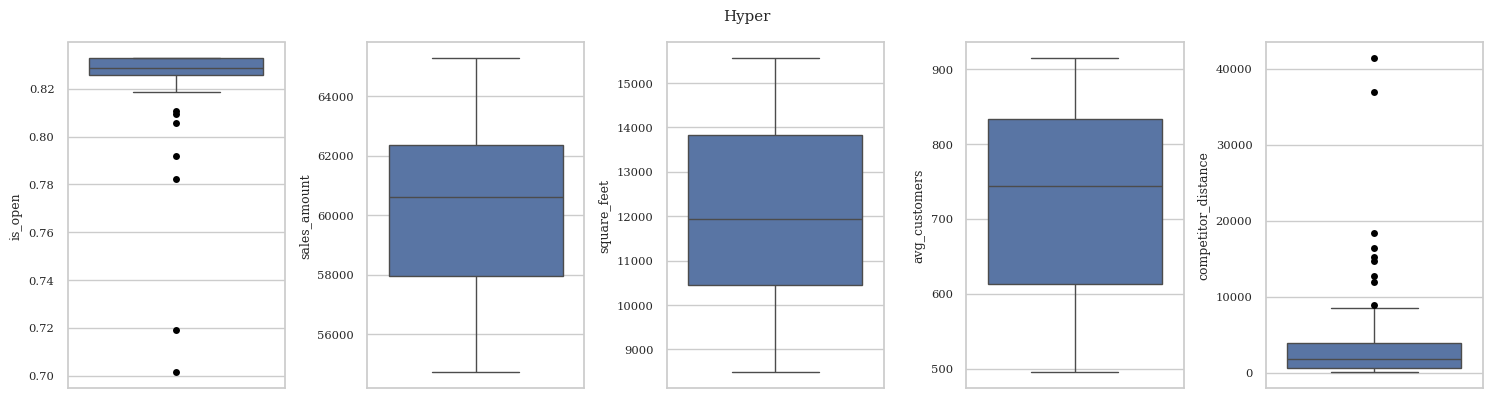

In [108]:
quant_names = ["is_open", "sales_amount", "square_feet", "avg_customers", "competitor_distance"]
for market_type in pd.unique(merged_df["market_type"]):
	merged_df_mt = merged_df[merged_df["market_type"] == market_type]

	fig, ax = plt.subplots(ncols = 5, nrows = 1, figsize = (15, 4))
	ax = ax.flatten()
	index = 0
	for col_name in quant_names:
		sns.boxplot(y = col_name, data = merged_df_mt, ax = ax[index],
			flierprops = {"marker": ".", "markersize": 10, "markerfacecolor": "black", "markeredgecolor": "none"})
		index += 1
	fig.suptitle(market_type.title())
	plt.tight_layout()
	plt.show()

It seems there are some outliers, let's see the outlier percentage per column. <br>
To check outliers (before fitting the model), one standard approach is to compute the `iqr` (interquartile range) and then check values that are:
- lower than $\text{quantile}(0.25) - 1.5 \cdot \text{iqr}$  or
- greater than $\text{quantile}(0.75) + 1.5 \cdot \text{iqr}$.

In [109]:
for market_type in pd.unique(merged_df["market_type"]):
	merged_df_mt = merged_df[merged_df["market_type"] == market_type].drop("market_type", axis = 1)
	
	print(str(market_type.title()) + ":")
	for col_name, col in merged_df_mt[quant_names].items():
		q1 = col.quantile(0.25)
		q3 = col.quantile(0.75)
		iqr = q3 - q1
		outliers_col = col[(col <= q1 - 1.5 * iqr) | (col >= q3 + 1.5 * iqr)]
		print("\t - " + col_name + ": " + str(round(len(outliers_col) / len(col) * 100, 2)) + "%")

Mini:
	 - is_open: 10.54%
	 - sales_amount: 0.0%
	 - square_feet: 0.0%
	 - avg_customers: 0.0%
	 - competitor_distance: 15.2%
Super:
	 - is_open: 2.0%
	 - sales_amount: 0.0%
	 - square_feet: 0.0%
	 - avg_customers: 0.0%
	 - competitor_distance: 2.4%
Hyper:
	 - is_open: 7.61%
	 - sales_amount: 0.0%
	 - square_feet: 0.0%
	 - avg_customers: 0.0%
	 - competitor_distance: 9.78%


### countplots

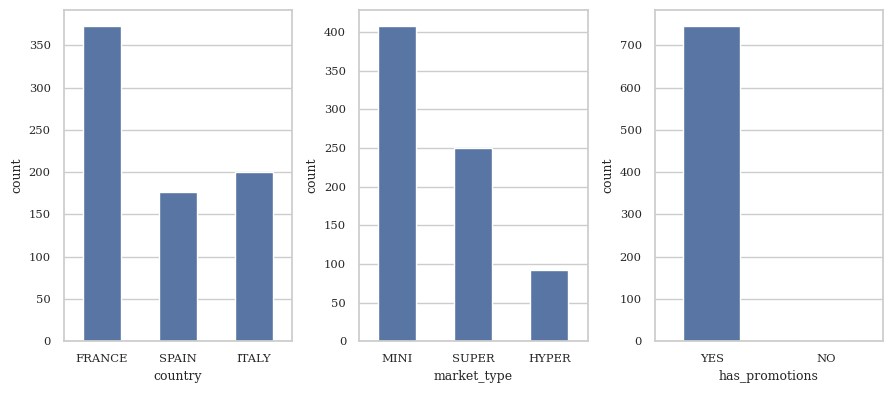

In [110]:
cat_names = ["country", "market_type", "has_promotions"]
fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (9, 4))
index = 0
ax = ax.flatten()
for col_name in cat_names:
	sns.countplot(x = col_name, data = merged_df, ax = ax[index], width = 0.5)
	index += 1
plt.tight_layout()

In [111]:
len(merged_df[merged_df["has_promotions"] == "NO"])

4

### ecode categorical variables

encode categorical variables

In [112]:
# split country and market_type
merged_df = pd.concat([merged_df, merged_df["country"].rename("is_france"), merged_df["country"].rename("is_italy"),
	merged_df["market_type"].rename("is_super"), merged_df["market_type"].rename("is_hyper")], axis = 1)
merged_df.rename(columns = {"country": "is_spain", "market_type": "is_mini"}, inplace = True)
merged_df = merged_df[["sales_amount", "is_open", "is_spain", "is_france", "is_italy", "is_mini", "is_super", "is_hyper",
	"square_feet", "avg_customers", "competitor_distance", "has_promotions"]]

# country
merged_df["is_spain"] = merged_df["is_spain"].map({"SPAIN": 1, "FRANCE": 0, "ITALY": 0})
merged_df["is_france"] = merged_df["is_france"].map({"SPAIN": 0, "FRANCE": 1, "ITALY": 0})
merged_df["is_italy"] = merged_df["is_italy"].map({"SPAIN": 0, "FRANCE": 0, "ITALY": 1})

# market_type
merged_df["is_mini"] = merged_df["is_mini"].map({"MINI": 1, "SUPER": 0, "HYPER": 0})
merged_df["is_super"] = merged_df["is_super"].map({"MINI": 0, "SUPER": 1, "HYPER": 0})
merged_df["is_hyper"] = merged_df["is_hyper"].map({"MINI": 0, "SUPER": 0, "HYPER": 1})

# has_promotions
merged_df["has_promotions"] = merged_df["has_promotions"].map({"YES": 1, "NO": 0})

display(merged_df)

,sales_amount,is_open,is_spain,is_france,is_italy,is_mini,is_super,is_hyper,square_feet,avg_customers,competitor_distance,has_promotions
0,12609.5795198675,0.8273972603,0,1,0,1,0,0,2437,248,58,1
1,26573.8142187500,0.8205128205,0,1,0,0,1,0,6403,493,300,1
2,26124.2837685950,0.8301369863,0,1,0,0,1,0,7544,340,1598,1
3,11856.3265178571,0.8205128205,1,0,0,1,0,0,1940,165,2068,1
4,12392.5510963455,0.8246575342,0,1,0,1,0,0,1486,166,750,1
...,...,...,...,...,...,...,...,...,...,...,...,...
745,12570.5495049505,0.8301369863,0,1,0,1,0,0,1691,272,1843,1
746,12375.2464732143,0.8205128205,0,1,0,1,0,0,1462,159,547,1
747,26404.8513079470,0.8273972603,0,1,0,0,1,0,5946,488,2743,1
748,12542.2565771812,0.8186813187,0,1,0,1,0,0,1413,239,1920,1


### scatterplot

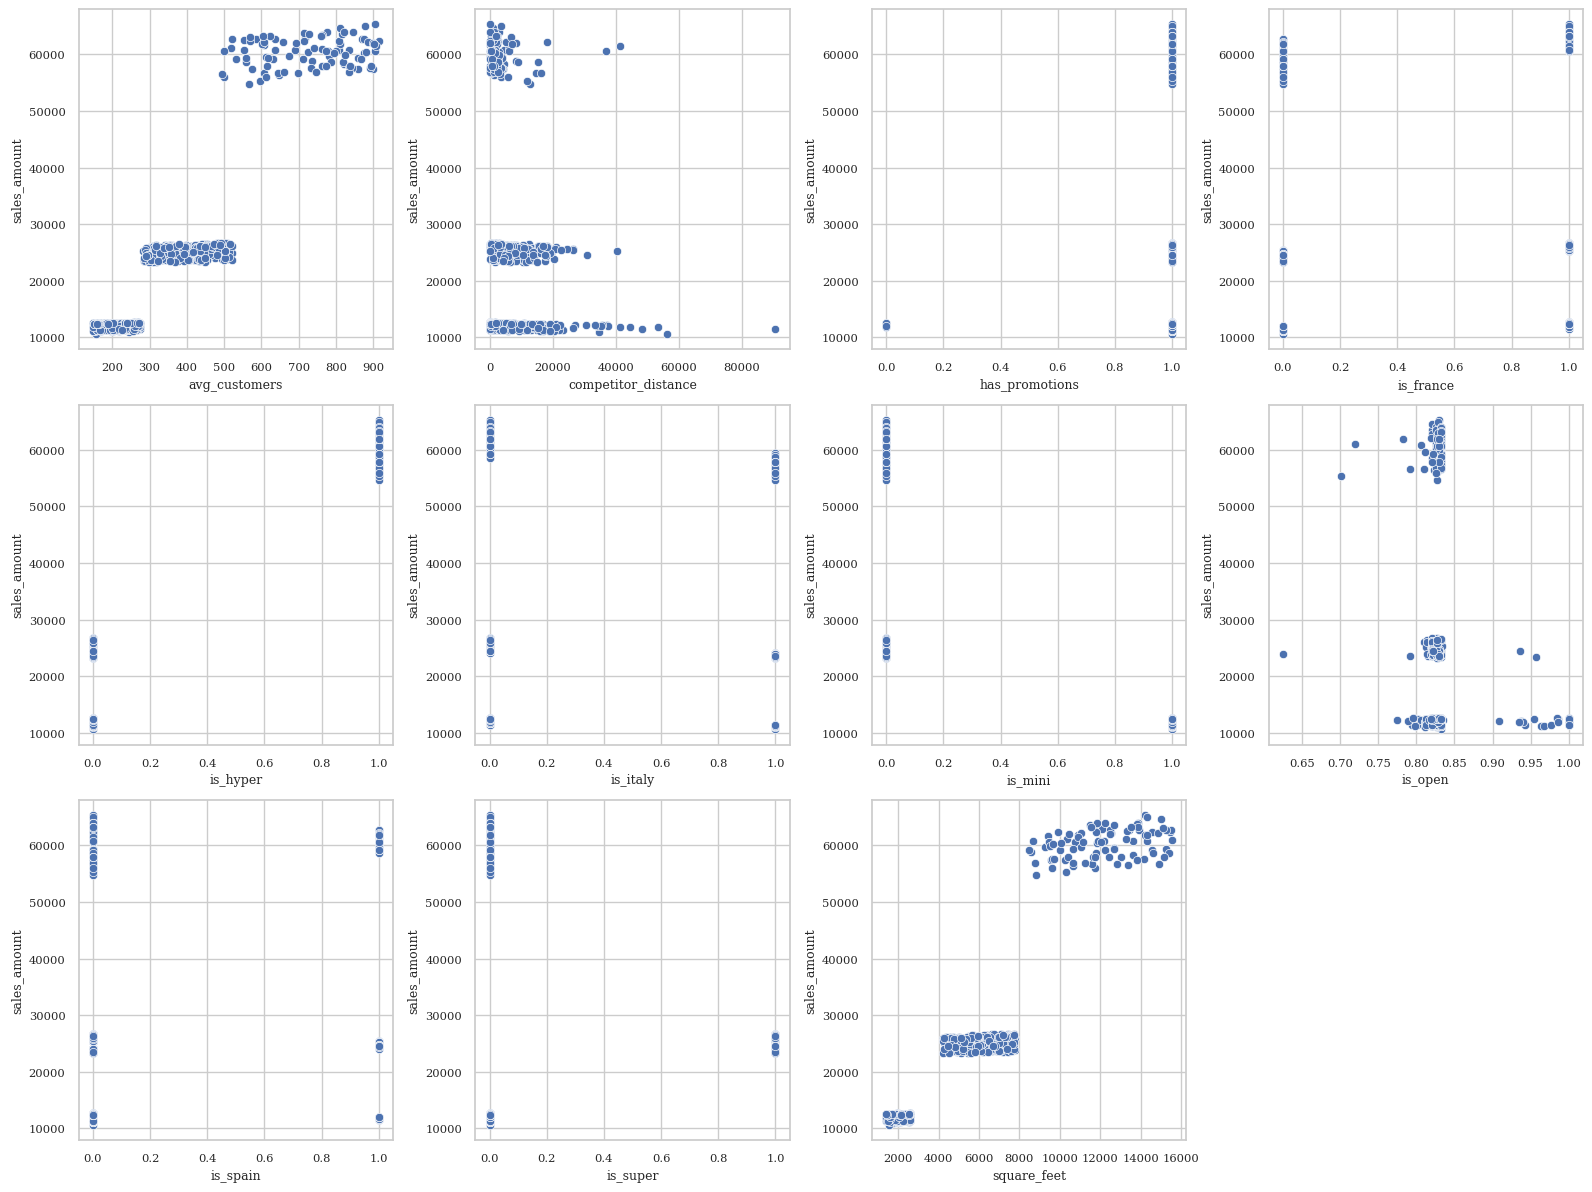

In [113]:
fig, ax = plt.subplots(ncols = 4, nrows = 3, figsize = (16, 12))
index = 0
ax = ax.flatten()
for col_name in merged_df.columns.difference(["sales_amount"]):
	current_plot = sns.scatterplot(y = merged_df["sales_amount"], x = merged_df[col_name], ax = ax[index])
	index = index + 1
ax[-1].axis("off")
plt.tight_layout()

### correlation matrix

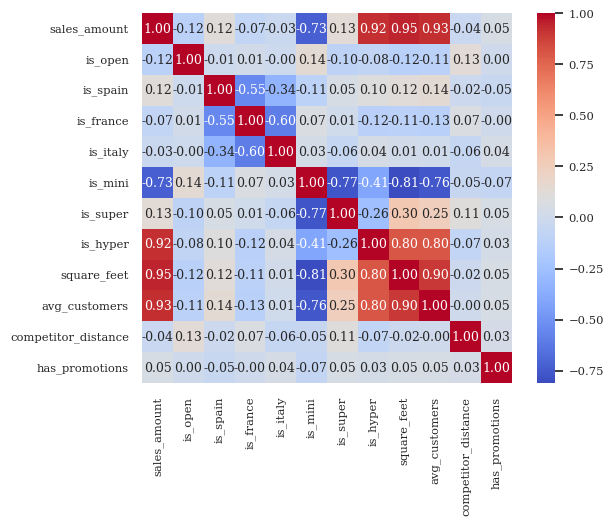

In [114]:
ax = sns.heatmap(merged_df.corr(), annot = True, cmap = "coolwarm", fmt = ".2f", square = True)
ax.tick_params(left = False, bottom = False)

# linear regression

In [115]:
merged_df

,sales_amount,is_open,is_spain,is_france,is_italy,is_mini,is_super,is_hyper,square_feet,avg_customers,competitor_distance,has_promotions
0,12609.5795198675,0.8273972603,0,1,0,1,0,0,2437,248,58,1
1,26573.8142187500,0.8205128205,0,1,0,0,1,0,6403,493,300,1
2,26124.2837685950,0.8301369863,0,1,0,0,1,0,7544,340,1598,1
3,11856.3265178571,0.8205128205,1,0,0,1,0,0,1940,165,2068,1
4,12392.5510963455,0.8246575342,0,1,0,1,0,0,1486,166,750,1
...,...,...,...,...,...,...,...,...,...,...,...,...
745,12570.5495049505,0.8301369863,0,1,0,1,0,0,1691,272,1843,1
746,12375.2464732143,0.8205128205,0,1,0,1,0,0,1462,159,547,1
747,26404.8513079470,0.8273972603,0,1,0,0,1,0,5946,488,2743,1
748,12542.2565771812,0.8186813187,0,1,0,1,0,0,1413,239,1920,1


## feature selection

funzioni

In [116]:
# define a function to calculate RSE, R2, and MSE
def calculate_metrics(y_test, y_pred, p):
	residuals = y_test - y_pred
	RSE = (sum(residuals ** 2) / (len(residuals) - p - 1)) ** 0.5
	R2 = 1 - sum(residuals ** 2) / sum((y_test - y_test.mean()) ** 2)
	MSE = (residuals ** 2).mean()
	return RSE, R2, MSE

def better_by_criteria(value_1, value_2, criteria):
	if (criteria == "RSE") or (criteria == "MSE"):
		return (value_1 < value_2)
	elif (criteria == "R2"):
		return (value_1 > value_2)

# forward selection
def forward_selection_v2(training_method, X, y, criteria, alpha = 0.1):
	# initialize kfold object to use for model evaluation
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 0)
	
	# initialize parameters
	p = X.shape[1]
	best_features = [[]] * p
	best_metrics_k = {
		"RSE": float("inf"),
		"R2": 0,
		"MSE": float("inf"),
	}
	best_metrics = []
	for _ in range(p):
		best_metrics.append(best_metrics_k.copy())
	current_features = []
	remaining_features = list(X.columns)
	
	# for each number of features
	for k in range(0, p):
		# for each combination of k number of features
		for new_feature in remaining_features:
			model_features = current_features + [new_feature]
			X_subset = X[model_features]
			# add a constant for the intercept term
			X_subset = sm.add_constant(X_subset)  
			# initialize empty array to store mse for each fold
			cv_folds = {
				"RSE": 0,
				"R2": 0,
				"MSE": 0,
				"len": 0
			}
			# for each fold fit the model and estimate cv test error (using the mean of MSE in all folds)
			for train_index, validation_index in kf.split(X_subset):
				X_train, X_validation = X_subset.iloc[train_index], X_subset.iloc[validation_index]
				y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
				if training_method == "OLS":
					model = sm.OLS(y_train, X_train).fit()
				elif training_method == "Ridge":
					model = Ridge(alpha = alpha).fit(X_train, y_train)
				elif training_method == "Lasso":
					model = Lasso(alpha = alpha).fit(X_train, y_train)
				else:
					print("error: " + training_method + " is not an available model")
					return
				y_pred = model.predict(X_validation)
				RSE, R2, MSE = calculate_metrics(y_validation, y_pred, k + 1)
				cv_folds["RSE"] = cv_folds["RSE"] + RSE
				cv_folds["R2"] = cv_folds["R2"] + R2
				cv_folds["MSE"] = cv_folds["MSE"] + MSE
				cv_folds["len"] = cv_folds["len"] + 1
			cv_folds = {key: cv_folds[key] / cv_folds["len"] for key in cv_folds.keys()}
			# if the estimation of the test error is reduced, save metrics and model
			if better_by_criteria(cv_folds[criteria], best_metrics[k][criteria], criteria):
				best_metrics[k]["RSE"] = cv_folds["RSE"]
				best_metrics[k]["R2"] = cv_folds["R2"]
				best_metrics[k]["MSE"] = cv_folds["MSE"]
				best_features[k] = model_features
		current_features = best_features[k]
		remaining_features = list(set(remaining_features) - set(current_features))
	return best_features, best_metrics

def plot_metrics(metrics, name_variables = "features"):
	p = len(metrics)
	_, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (12, 4))
	index = 0
	ax = ax.flatten()
	for error_type in ["RSE", "R2", "MSE"]:
		error_list = [metrics[k][error_type] for k in range(p)]
		sns.lineplot(x = range(1, p + 1), y = error_list, ax = ax[index])
		sns.scatterplot(x = range(1, p + 1), y = error_list, ax = ax[index])
		ax[index].set_title(error_type)
		ax[index].set_xlabel("k (n. " + name_variables + ")")
		ax[index].set_ylabel(error_type + "(k)")
		index = index + 1
	plt.tight_layout()
	plt.show()

def report_best_parameters(features, metrics, criteria, model_name = "", verbose = True):
	p = len(metrics)
	criteria_list = [metrics[k][criteria] for k in range(p)]
	if (criteria == "RSE") or (criteria == "MSE"):
		criteria_best_k = criteria_list.index(min(criteria_list))
	elif (criteria == "R2"):
		criteria_best_k = criteria_list.index(max(criteria_list))
	if verbose == True:
		print(model_name, "model:\n\t- k =", criteria_best_k + 1, "\n\t- model =", features[criteria_best_k])
		print(model_name, "metrics:\n\t- RSE:", metrics[criteria_best_k]["RSE"])
		print("\t- R2:", metrics[criteria_best_k]["R2"])
		print("\t- MSE:", metrics[criteria_best_k]["MSE"])
	return features[criteria_best_k], metrics[criteria_best_k]

regressione normale

ols best model:
	- k = 7 
	- model = ['square_feet', 'is_hyper', 'is_super', 'is_italy', 'is_spain', 'avg_customers', 'competitor_distance']
ols best metrics:
	- RSE: 650.9904643060594
	- R2: 0.9982955947083116
	- MSE: 404002.961247275


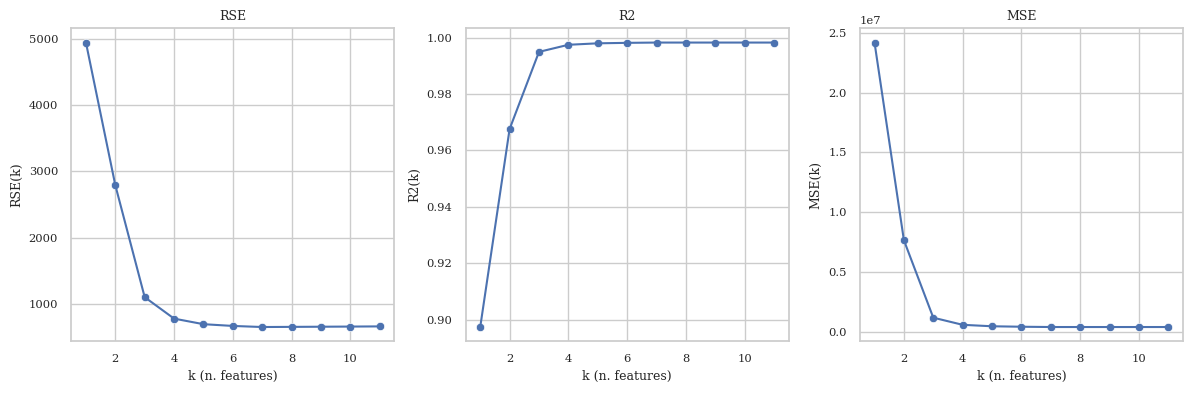

In [117]:
# model
model_name = "ols best"

# load the dataset
X = merged_df.loc[:, merged_df.columns != "sales_amount"]
y = merged_df["sales_amount"]

# calculate and display the results
criteria = "RSE"
training_method = "OLS"
all_best_features, all_best_metrics = forward_selection_v2(training_method, X, y, criteria)
best_features, best_metrics = report_best_parameters(all_best_features, all_best_metrics, criteria, model_name)
plot_metrics(all_best_metrics)

# store cv errors
cv_errors = pd.DataFrame([best_metrics])
cv_errors = cv_errors.rename(index = {0: model_name})

abbiamo usato l'RSE perchè ci permetteva di escludere il numero maggiori di variabili ottenendo un'accuratezza praticamente identica agli altri 2 casi

## analysis of the best linear model

### model fit and coefficient analysis

In [118]:
# split in train and test
X = merged_df[best_features]
y = merged_df["sales_amount"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# fit the linear regression model
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train_with_intercept).fit()

# model accuracy (RSE, R2 and MSE)
y_pred = model.predict(X_test_with_intercept)
RSE, R2, MSE = calculate_metrics(y_test, y_pred, p = X_train.shape[1])
print("test errors:\n\t- RSE:", RSE, "\n\t- R2:", R2, "\n\t- MSE:", MSE)

test errors:
	- RSE: 691.7937075177307 
	- R2: 0.9981523042239946 
	- MSE: 453054.3452938671


In [119]:
# coefficient estimates 
coefficients = model.params

# dataframe with all coefficients and stats of interest 
rows = []
for index, value in coefficients.items():
	row = [index, value, model.bse[index], model.tvalues[index], model.pvalues[index]]
	rows.append(row)
summary_coeff = pd.DataFrame(rows, columns = ["", "ols estimation", "SE", "t-stats", "p-value"])
summary_coeff

,,ols estimation,SE,t-stats,p-value
0,const,11683.8244623423,104.4479658165,111.8626329484,0.0000000000e+00
1,square_feet,0.2522506874,0.0262496295,9.6096856252,2.0490592698e-20
2,is_hyper,44204.4214402626,338.5221897027,130.5805728100,0.0000000000e+00
3,is_super,11519.7982188595,139.3385454534,82.6748849816,0.0000000000e+00
4,is_italy,-2024.9633296618,60.7076959014,-33.3559575865,4.5010794922e-138
5,is_spain,-917.3375997626,63.3769245386,-14.4743154775,7.1739563993e-41
6,avg_customers,3.2475620563,0.3872427029,8.3863737962,3.6775426500e-16
7,competitor_distance,-0.0172665253,0.0030435867,-5.6730847302,2.1958347762e-08


In [120]:
# 95% confidence intervals
confidence_intervals = model.conf_int(alpha = 0.05)  # 0.05 for a 95% confidence interval

print("the 95% confidence intervals:")
for index, value in coefficients.items():
    current_conf_int = confidence_intervals.loc[index].values
    print("\t - ",index, "is", current_conf_int)

the 95% confidence intervals:
	 -  const is [11478.69082317 11888.95810152]
	 -  square_feet is [0.20069696 0.30380442]
	 -  is_hyper is [43539.57087881 44869.27200171]
	 -  is_super is [11246.14020472 11793.456233  ]
	 -  is_italy is [-2144.19198566 -1905.73467366]
	 -  is_spain is [-1041.80856546  -792.86663406]
	 -  avg_customers is [2.48702542 4.0080987 ]
	 -  competitor_distance is [-0.02324407 -0.01128898]


### residuals analysis

#### correlation of error terms

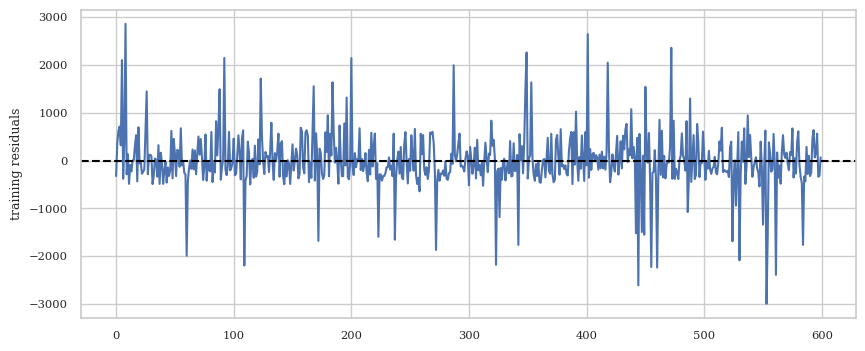

In [121]:
residuals_training = model.resid

plt.figure(figsize = (10, 4))
fig = sns.lineplot(x = range(0, len(residuals_training)), y = residuals_training)
fig.axhline(0, linestyle = "--", color = "black")
plt.ylabel("training residuals")
plt.show()

In [122]:
# autocorrelation
lagged_residuals = residuals_training.shift(1)
autocorrelation = (residuals_training.corr(lagged_residuals)) ** 2

# durbin_watson
durbin_watson = sm.stats.durbin_watson(residuals_training)
print("- autocorrelation:", round(autocorrelation, 5), "\n- durbin-watson statistic:", round(durbin_watson, 5))

- autocorrelation: 0.00015 
- durbin-watson statistic: 1.97482


suggesting that error terms are not correlated

#### analysis of homoskedasticity/heteroskedasticity

In [123]:
mini_index = merged_df[merged_df["is_mini"] == 1].index
super_index = merged_df[merged_df["is_super"] == 1].index
hyper_index = merged_df[merged_df["is_hyper"] == 1].index
list_index = [mini_index, super_index, hyper_index]
list_names = ["Mini", "Super", "Hyper"]

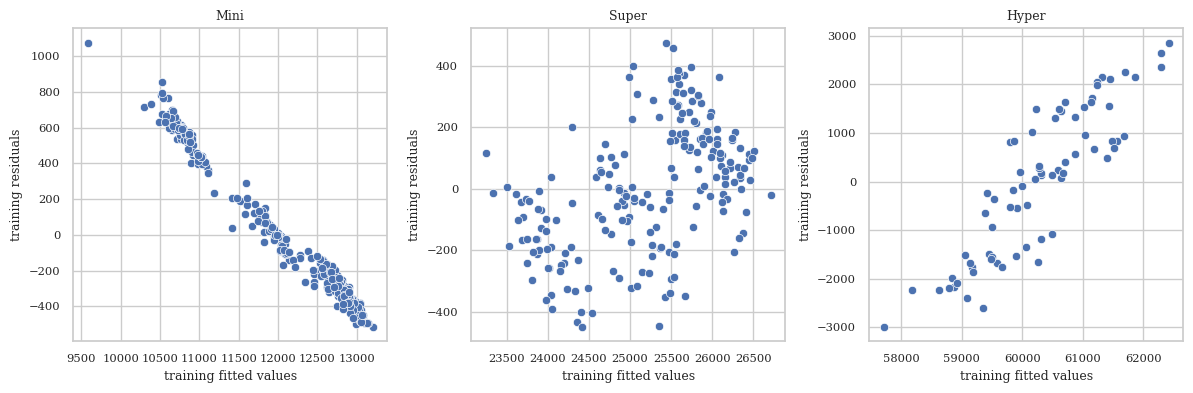

In [124]:
# variance of error terms: residuals vs fitted values
_, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (12, 4))
index = 0
ax = ax.flatten()
for index in range(3):
	remove_indexes = list_index[:index] + list_index[(index + 1):]
	X_train_with_intercept_market = X_train_with_intercept.loc[X_train_with_intercept.index.difference(remove_indexes[0]).difference(remove_indexes[1])]
	residuals_training_market = residuals_training.loc[residuals_training.index.difference(remove_indexes[0]).difference(remove_indexes[1])]
	sns.scatterplot(x = model.predict(X_train_with_intercept_market), y = residuals_training_market, ax = ax[index])
	ax[index].set_title(list_names[index])
	ax[index].set_xlabel("training fitted values")
	ax[index].set_ylabel("training residuals")
	index = index + 1
plt.tight_layout()

In [125]:
name = ["lagrange multiplier statistic", "p-value"]
test = sm.stats.het_breuschpagan(residuals_training, model.model.exog)
print("- lagrange multiplier statistic:", lzip(name, test)[0][1], "\n- p-value:", lzip(name, test)[1][1])

- lagrange multiplier statistic: 320.6528343630137 
- p-value: 2.3379788581370095e-65


### collinearity

In [126]:
# collinearity
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["Feature"] = X_train.columns
vif

,VIF Factor,Feature
0,27.7390752903,square_feet
1,8.0279542955,is_hyper
2,5.3305830598,is_super
3,1.5185551822,is_italy
4,1.5165200902,is_spain
5,15.3690613884,avg_customers
6,1.4464041152,competitor_distance


## solution to heteroskedasticity: log of the target

### feature selection

ols best log model:
	- k = 7 
	- model = ['square_feet', 'is_mini', 'is_super', 'is_italy', 'is_spain', 'competitor_distance', 'avg_customers']
ols best log metrics:
	- RSE: 0.0024444511543712626
	- R2: 0.999981294166683
	- MSE: 5.705157292016128e-06


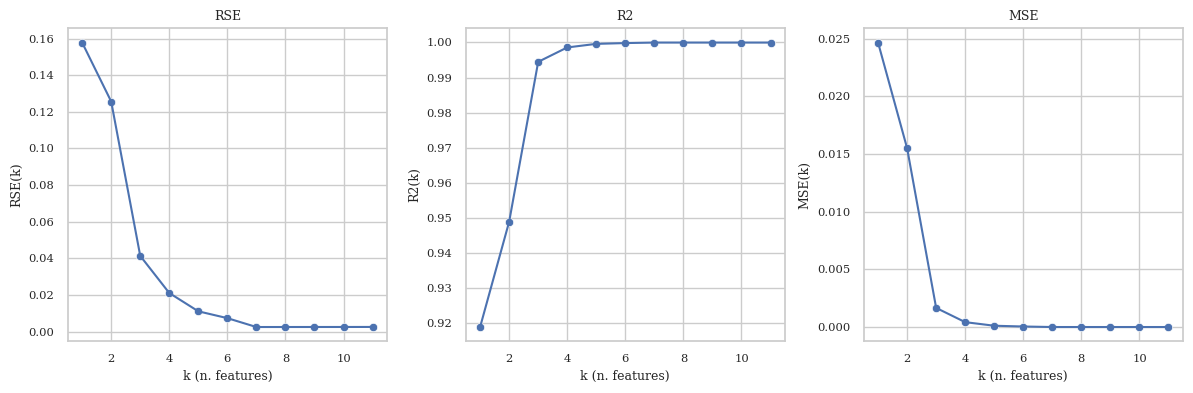

In [127]:
model_name = "ols best log"

X = merged_df.loc[:, merged_df.columns != "sales_amount"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns = X.columns)

# X = merged_df.loc[:, merged_df.columns != "sales_amount"]
y = np.log(merged_df["sales_amount"])

criteria = "RSE"
training_method = "OLS"
all_best_features, all_best_metrics = forward_selection_v2(training_method, X, y, criteria)
best_features, best_metrics = report_best_parameters(all_best_features, all_best_metrics, criteria, model_name)
plot_metrics(all_best_metrics)

cv_errors = pd.concat([cv_errors, pd.DataFrame([best_metrics])])
cv_errors = cv_errors.rename(index = {0: model_name})

### analysis of the best linear model

In [128]:
# split in train and test
X = merged_df[best_features]
y = np.log(merged_df["sales_amount"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# fit the linear regression model
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train_with_intercept).fit()

# model accuracy (RSE, R2 and MSE)
y_pred = model.predict(X_test_with_intercept)
RSE, R2, MSE = calculate_metrics(y_test, y_pred, p = X_train.shape[1])
print("test errors:\n\t- RSE:", RSE, "\n\t- R2:", R2, "\n\t- MSE:", MSE)

test errors:
	- RSE: 0.0028288763727871377 
	- R2: 0.9999756606456307 
	- MSE: 7.575739317445936e-06


In [129]:
# coefficient estimates 
coefficients = model.params

# dataframe with all coefficients and stats of interest 
rows = []
for index, value in coefficients.items():
	row = [index, value, model.bse[index], model.tvalues[index], model.pvalues[index]]
	rows.append(row)
summary_coeff = pd.DataFrame(rows, columns = ["", "ols estimation", "SE", "t-stats", "p-value"])
summary_coeff

,,ols estimation,SE,t-stats,p-value
0,const,10.9104406315,0.0015885810,6868.0416826252,0.0000000000e+00
1,square_feet,0.0000058677,0.0000000977,60.0351771339,6.1603621639e-254
2,is_mini,-1.5072641391,0.0012604409,-1195.8229303327,0.0000000000e+00
3,is_super,-0.8118967661,0.0008132052,-998.3909788707,0.0000000000e+00
4,is_italy,-0.0952456552,0.0002260368,-421.3723901658,0.0000000000e+00
5,is_spain,-0.0463331341,0.0002359753,-196.3474065317,0.0000000000e+00
6,competitor_distance,-0.0000010250,0.0000000113,-90.4502433683,0.0000000000e+00
7,avg_customers,0.0001030924,0.0000014418,71.5003377242,2.0448898094e-293


In [130]:
# 95% confidence intervals
confidence_intervals = model.conf_int(alpha = 0.05)  # 0.05 for a 95% confidence interval

print("the 95% confidence intervals:")
for index, value in coefficients.items():
    current_conf_int = confidence_intervals.loc[index].values
    print("\t - ",index, "is", current_conf_int)

the 95% confidence intervals:
	 -  const is [10.90732069 10.91356057]
	 -  square_feet is [5.67569842e-06 6.05960488e-06]
	 -  is_mini is [-1.50973962 -1.50478866]
	 -  is_super is [-0.81349388 -0.81029965]
	 -  is_italy is [-0.09568959 -0.09480172]
	 -  is_spain is [-0.04679658 -0.04586968]
	 -  competitor_distance is [-1.04727284e-06 -1.00275973e-06]
	 -  avg_customers is [0.00010026 0.00010592]


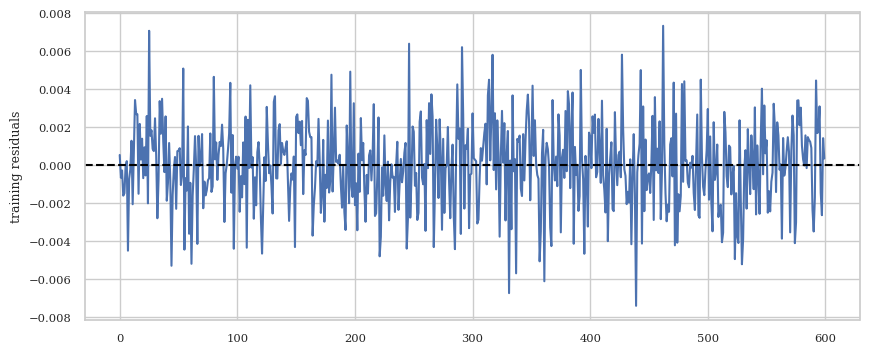

In [131]:
residuals_training = model.resid

plt.figure(figsize = (10, 4))
fig = sns.lineplot(x = range(0, len(residuals_training)), y = residuals_training)
fig.axhline(0, linestyle = "--", color = "black")
plt.ylabel("training residuals")
plt.show()

In [132]:
# autocorrelation
lagged_residuals = residuals_training.shift(1)
autocorrelation = (residuals_training.corr(lagged_residuals)) ** 2

# durbin_watson
durbin_watson = sm.stats.durbin_watson(residuals_training)
print("- autocorrelation:", round(autocorrelation, 5), "\n- durbin-watson statistic:", round(durbin_watson, 5))

- autocorrelation: 2e-05 
- durbin-watson statistic: 2.00819


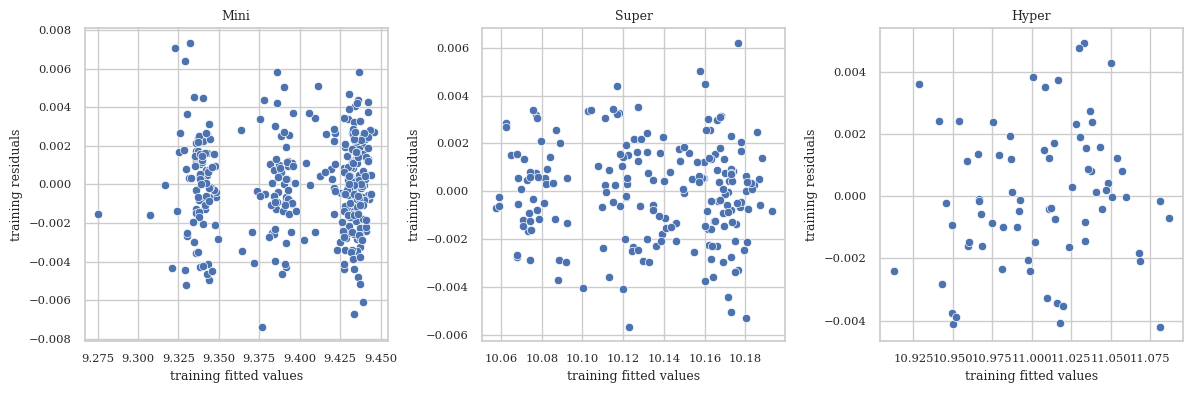

In [133]:
# variance of error terms: residuals vs fitted values
_, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (12, 4))
index = 0
ax = ax.flatten()
for index in range(3):
	remove_indexes = list_index[:index] + list_index[(index + 1):]
	X_train_with_intercept_market = X_train_with_intercept.loc[X_train_with_intercept.index.difference(remove_indexes[0]).difference(remove_indexes[1])]
	residuals_training_market = residuals_training.loc[residuals_training.index.difference(remove_indexes[0]).difference(remove_indexes[1])]
	sns.scatterplot(x = model.predict(X_train_with_intercept_market), y = residuals_training_market, ax = ax[index])
	ax[index].set_title(list_names[index])
	ax[index].set_xlabel("training fitted values")
	ax[index].set_ylabel("training residuals")
	index = index + 1
plt.tight_layout()

In [134]:
name = ["lagrange multiplier statistic", "p-value"]
test = sm.stats.het_breuschpagan(residuals_training, model.model.exog)
print("- lagrange multiplier statistic:", lzip(name, test)[0][1], "\n- p-value:", lzip(name, test)[1][1])

- lagrange multiplier statistic: 12.186822611344471 
- p-value: 0.09458008360663923


In [135]:
# collinearity
vif = pd.DataFrame()
vif["VIF factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["feature"] = X_train.columns
vif

,VIF factor,feature
0,16.9491945723,square_feet
1,2.1551709097,is_mini
2,1.9206173561,is_super
3,1.5573512909,is_italy
4,1.5362269442,is_spain
5,1.4757043139,competitor_distance
6,20.7864663851,avg_customers


### backward selection

In [136]:
# backward selection
def backward_selection_v2(training_method, X, y, criteria, alpha = 0.1):
	# initialize kfold object to use for model evaluation
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 0)
	
	# initialize parameters
	p = X.shape[1]
	best_features = [[]] * p
	best_metrics_k = {
		"RSE": float("inf"),
		"R2": 0,
		"MSE": float("inf"),
	}
	best_metrics = []
	for _ in range(p):
		best_metrics.append(best_metrics_k.copy())
	current_features = list(X.columns)
	removable_features = [" "]
	
	# for each number of features
	for k in range(p, 0, -1):
		for new_feature in removable_features:
			model_features = list(set(current_features) - set([new_feature]))
			X_subset = X[model_features]
			# add a constant for the intercept term
			X_subset = sm.add_constant(X_subset)  
			# initialize empty array to store mse for each fold
			cv_folds = {
				"RSE": 0,
				"R2": 0,
				"MSE": 0,
				"len": 0
			}
			# for each fold fit the model and estimate cv test error (using the mean of MSE in all folds)
			for train_index, validation_index in kf.split(X_subset):
				X_train, X_validation = X_subset.iloc[train_index], X_subset.iloc[validation_index]
				y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
				if training_method == "OLS":
					model = sm.OLS(y_train, X_train).fit()
				elif training_method == "Ridge":
					model = Ridge(alpha = alpha).fit(X_train, y_train)
				elif training_method == "Lasso":
					model = Lasso(alpha = alpha).fit(X_train, y_train)
				else:
					print("error: " + training_method + " is not an available model")
					return
				y_pred = model.predict(X_validation)
				RSE, R2, MSE = calculate_metrics(y_validation, y_pred, k)
				cv_folds["RSE"] = cv_folds["RSE"] + RSE
				cv_folds["R2"] = cv_folds["R2"] + R2
				cv_folds["MSE"] = cv_folds["MSE"] + MSE
				cv_folds["len"] = cv_folds["len"] + 1
			cv_folds = {key: cv_folds[key] / cv_folds["len"] for key in cv_folds.keys()}
			# if the estimation of the test error is reduced, save metrics and model
			if better_by_criteria(cv_folds[criteria], best_metrics[k - 1][criteria], criteria):
				best_metrics[k - 1]["RSE"] = cv_folds["RSE"]
				best_metrics[k - 1]["R2"] = cv_folds["R2"]
				best_metrics[k - 1]["MSE"] = cv_folds["MSE"]
				best_features[k - 1] = model_features
		current_features = best_features[k - 1]
		removable_features = current_features
	return best_features, best_metrics

ols best log (backward) model:
	- k = 7 
	- model = ['square_feet', 'is_spain', 'is_hyper', 'is_super', 'is_france', 'competitor_distance', 'avg_customers']
ols best log (backward) metrics:
	- RSE: 0.0024444511543951475
	- R2: 0.9999812941666828
	- MSE: 5.705157292094478e-06


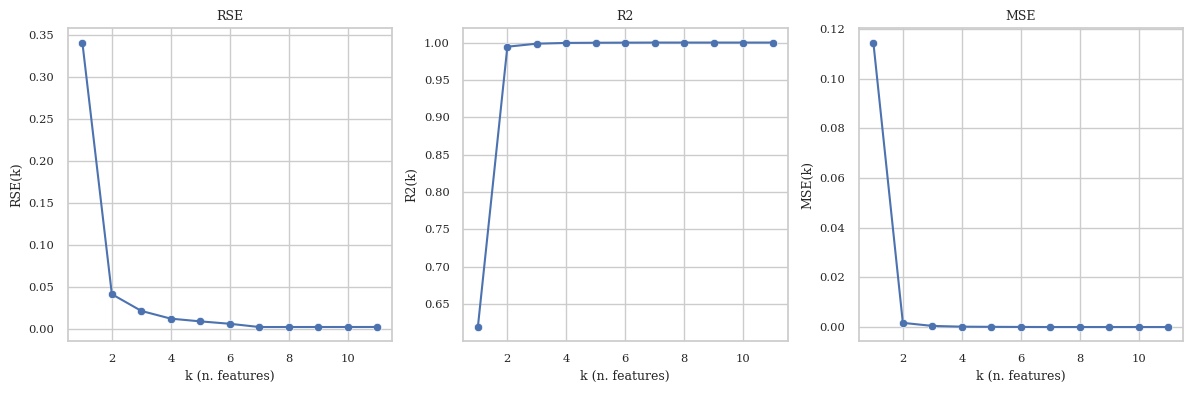

In [137]:
model_name = "ols best log (backward)"

X = merged_df.loc[:, merged_df.columns != "sales_amount"]
y = np.log(merged_df["sales_amount"])

criteria = "RSE"
training_method = "OLS"
all_best_features, all_best_metrics = backward_selection_v2(training_method, X, y, criteria)
best_features, best_metrics = report_best_parameters(all_best_features, all_best_metrics, criteria, model_name)
plot_metrics(all_best_metrics)

seleziona lo stesso modello (evviva)

## feature selection with ridge/lasso

only log of the target

In [138]:
X = merged_df.loc[:, merged_df.columns != "sales_amount"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
y = np.log(merged_df["sales_amount"])

criteria = "RSE"
alpha_values = [0.001, 0.01, 0.1, 1]

In [139]:
model_name = "ridge best"
training_method = "Ridge"
print(training_method + ":")
best_alpha = 0
best_alpha_metrics = {
	"RSE": float("inf"),
	"R2": 0,
	"MSE": float("inf"),
	"features": [],
	"k": 0,
}
for alpha in alpha_values:
	all_best_features, all_best_metrics = forward_selection_v2(training_method, X_scaled, y, criteria, alpha = alpha)
	best_features, best_metrics = report_best_parameters(all_best_features, all_best_metrics, criteria, verbose = False)
	if best_metrics["RSE"] < best_alpha_metrics["RSE"]:
		best_alpha_metrics["RSE"] = best_metrics["RSE"]
		best_alpha_metrics["R2"] = best_metrics["R2"]
		best_alpha_metrics["MSE"] = best_metrics["MSE"]
		best_alpha_metrics["features"] = best_features
		best_alpha_metrics["k"] = len(best_features)
		best_alpha = alpha
print("\t" + model_name, "model:\n\t\t- alpha =", best_alpha,"\n\t\t- k =", best_alpha_metrics["k"], "\n\t\t- model =", best_alpha_metrics["features"])
print("\t" + model_name, "metrics:\n\t\t- RSE:", best_alpha_metrics["RSE"])
print("\t\t- R2:", best_alpha_metrics["R2"])
print("\t\t- MSE:", best_alpha_metrics["MSE"])

cv_errors = pd.concat([cv_errors, pd.DataFrame([{key: value for key, value in best_alpha_metrics.items() if key not in ["k", "features"]}])])
cv_errors = cv_errors.rename(index = {0: model_name})

Ridge:
	ridge best model:
		- alpha = 0.001 
		- k = 7 
		- model = ['square_feet', 'is_mini', 'is_hyper', 'is_italy', 'is_france', 'competitor_distance', 'avg_customers']
	ridge best metrics:
		- RSE: 0.002444462972930091
		- R2: 0.9999812939350894
		- MSE: 5.705197989734064e-06


In [140]:
model_name = "lasso best"
training_method = "Lasso"
print(training_method + ":")
best_alpha = 0
best_alpha_metrics = {
	"RSE": float("inf"),
	"R2": 0,
	"MSE": float("inf"),
	"features": [],
	"k": 0,
}
for alpha in alpha_values:
	all_best_features, all_best_metrics = forward_selection_v2(training_method, X_scaled, y, criteria, alpha = alpha)
	best_features, best_metrics = report_best_parameters(all_best_features, all_best_metrics, criteria, verbose = False)
	if best_metrics["RSE"] < best_alpha_metrics["RSE"]:
		best_alpha_metrics["RSE"] = best_metrics["RSE"]
		best_alpha_metrics["R2"] = best_metrics["R2"]
		best_alpha_metrics["MSE"] = best_metrics["MSE"]
		best_alpha_metrics["features"] = best_features
		best_alpha_metrics["k"] = len(best_features)
		best_alpha = alpha
print("\t" + model_name, "model:\n\t\t- alpha =", best_alpha,"\n\t\t- k =", best_alpha_metrics["k"], "\n\t\t- model =", best_alpha_metrics["features"])
print("\t" + model_name, "metrics:\n\t\t- RSE:", best_alpha_metrics["RSE"])
print("\t\t- R2:", best_alpha_metrics["R2"])
print("\t\t- MSE:", best_alpha_metrics["MSE"])

cv_errors = pd.concat([cv_errors, pd.DataFrame([{key: value for key, value in best_alpha_metrics.items() if key not in ["k", "features"]}])])
cv_errors = cv_errors.rename(index = {0: model_name})

Lasso:
	lasso best model:
		- alpha = 0.001 
		- k = 7 
		- model = ['square_feet', 'is_mini', 'is_hyper', 'is_italy', 'is_france', 'competitor_distance', 'avg_customers']
	lasso best metrics:
		- RSE: 0.0032928489780779295
		- R2: 0.9999658694059155
		- MSE: 1.0329360525402506e-05


## dimensionality reduction

### PCA

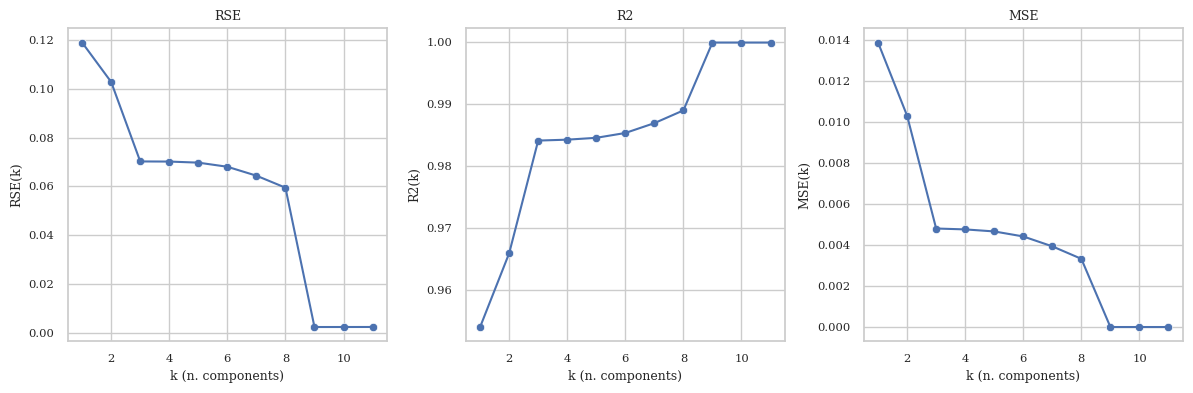

In [141]:
# PCA
def pca_regression(X, y):
	# initialize kfold object to use for model evaluation
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 0)

	# standardize features by removing the mean and scaling to unit variance
	scaler = StandardScaler()
	X_scaled = scaler.fit_transform(X)
	X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

	# initialize parameters
	p = X_scaled.shape[1]
	errors_pca_k = {
		"RSE": float("inf"),
		"R2": 0,
		"MSE": float("inf"),
	}
	errors_pca = []
	for _ in range(p):
		errors_pca.append(errors_pca_k.copy())

	# for each number of principal components
	for k in range(1, p + 1):
		# transform using n_components for PCA
		pca = PCA(n_components = k)
		X_pca = pca.fit_transform(X_scaled)
		X_pca = pd.DataFrame(X_pca)
		# add a constant for the intercept term
		X_pca = sm.add_constant(X_pca)  
		# initialize empty array to store mse for each fold
		cv_folds = {
			"RSE": 0,
			"R2": 0,
			"MSE": 0,
			"len": 0
		}
		# for each fold fit the model
		for train_index, validation_index in kf.split(X_pca):
			X_train, X_validation = X_pca.iloc[train_index], X_pca.iloc[validation_index]
			y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
			model = sm.OLS(y_train, X_train).fit()
			y_pred = model.predict(X_validation)
			RSE, R2, MSE = calculate_metrics(y_validation, y_pred, X_train.shape[1])
			cv_folds["RSE"] = cv_folds["RSE"] + RSE
			cv_folds["R2"] = cv_folds["R2"] + R2
			cv_folds["MSE"] = cv_folds["MSE"] + MSE
			cv_folds["len"] = cv_folds["len"] + 1
		cv_folds = {key: cv_folds[key] / cv_folds["len"] for key in cv_folds.keys()}
		# save errors
		errors_pca[k - 1]["RSE"] = cv_folds["RSE"]
		errors_pca[k - 1]["R2"] = cv_folds["R2"]
		errors_pca[k - 1]["MSE"] = cv_folds["MSE"]
	return errors_pca

X = merged_df.loc[:, merged_df.columns != "sales_amount"]
y = np.log(merged_df["sales_amount"])

errors_pca = pca_regression(X, y)
plot_metrics(errors_pca, "components")

non è utile fare pca (si vede dai plot). <br>
in realtà ce lo aspettavamo perchè la pca non è un metodo indicato nel caso in cui si abbiamo sia variabili categoriale che variabili quantitative. <br>
l'effetto della standardizzazione dipende dalla numerosità delle categorie e non è perfettamente chiaro quale sia la loro influenza.

note: avendo standardizzato i predittori in teoria non sarebbe possibile arrivare a trovare i delta changes (risalire ai coefficienti della regressione rispetto ai predittori originali). comunque noi non lo dobbiamo fare

### PLS

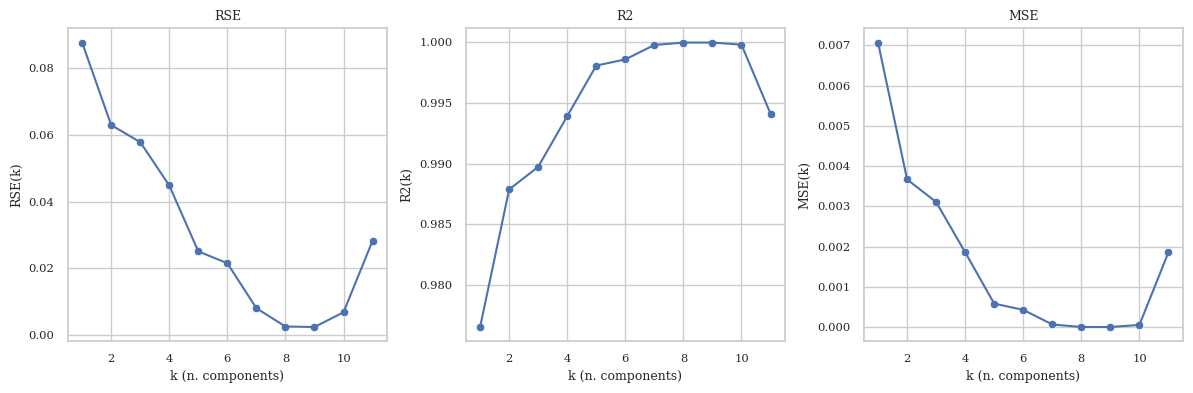

In [142]:
# PLS
def pls_regression(X, y):
	# initialize kfold object to use for model evaluation
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 0)

	# standardize features by removing the mean and scaling to unit variance
	scaler = StandardScaler()
	X_scaled = scaler.fit_transform(X)
	X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

	# initialize parameters
	p = X_scaled.shape[1]
	errors_pls_k = {
		"RSE": float("inf"),
		"R2": 0,
		"MSE": float("inf"),
	}
	errors_pls = []
	for _ in range(p):
		errors_pls.append(errors_pls_k.copy())

	# for each number of principal components
	for k in range(1, p + 1):
		# transform using n_components for PLS
		pls = PLSRegression(n_components = k) 
		# initialize empty array to store mse for each fold
		cv_folds = {
			"RSE": 0,
			"R2": 0,
			"MSE": 0,
			"len": 0
		}
		# for each fold fit the model
		for train_index, validation_index in kf.split(X_scaled):
			X_train, X_validation = X_scaled.iloc[train_index], X_scaled.iloc[validation_index]
			y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
			pls.fit(X_train, y_train)
			y_pred = pls.predict(X_validation)
			y_pred = pd.Series(y_pred)
			RSE, R2, MSE = calculate_metrics(y_validation.reset_index(drop = True), y_pred, X_train.shape[1]) 
			cv_folds["RSE"] = cv_folds["RSE"] + RSE
			cv_folds["R2"] = cv_folds["R2"] + R2
			cv_folds["MSE"] = cv_folds["MSE"] + MSE
			cv_folds["len"] = cv_folds["len"] + 1
		cv_folds = {key: cv_folds[key] / cv_folds["len"] for key in cv_folds.keys()}
		# save errors
		errors_pls[k - 1]["RSE"] = cv_folds["RSE"]
		errors_pls[k - 1]["R2"] = cv_folds["R2"]
		errors_pls[k - 1]["MSE"] = cv_folds["MSE"]
	return errors_pls

errors_pls = pls_regression(X, y)
plot_metrics(errors_pls, "components")

non è utile fare pls (si vede dai plot)

### conclusions

In [143]:
pd.set_option('display.precision', 10)
display(cv_errors)

,RSE,R2,MSE
ols best,650.9904643061,0.9982955947,404002.9612472750
ols best log,0.0024444512,0.9999812942,0.0000057052
ridge best,0.0024444630,0.9999812939,0.0000057052
lasso best,0.0032928490,0.9999658694,0.0000103294


# other methods

il dataset che consideriamo per fare predizione è merged_df senza le variabili ridondanti relative a country e market_type (is_france e is_hyper), che erano derivanti dalla traduzione in variabili booleane. 

in realtà da questo punto in poi ci restringiamo a considerare le best features ottenute con la regressione lineare (con predictor log(y)). <br> 
in teoria andrebbe fatta la feature selection per ogni metodo a partire dal dataset merged_df (da cui come avevamo detto in precedenza sarebbe più corretto rimuovere is_france e is_hyper), però non lo facciamo perchè:
- per evitare di appesantire la relazione;
- abbiamo già appurato che usando solo quelle variabili si riesce ad ottenere un'accuratezza altissima.
  
inoltre standardizziamo i dati perchè gli altri metodi potrebbero essere falsati dalla differenza in termini di ordini di grandezza e di varianza. <br>
da questo momento in poi utilizzeremo X_scaled = standardized(X) come dataframe dei predictors ed y come target series. 

utilizzeremo solo l'mse per confrontare l'accuratezza dei parametri.

In [144]:
X = merged_df[['square_feet', 'is_mini', 'is_super', 'is_italy', 'is_spain', 'competitor_distance', 'avg_customers']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
y = np.log(merged_df[['sales_amount']])
display(X_scaled, y)

,square_feet,is_mini,is_super,is_italy,is_spain,competitor_distance,avg_customers
0,-0.6184314146,0.9155519068,-0.7071067812,-0.6030226892,-0.5557882003,-0.6603960685,-0.4955551468
1,0.5170829847,-1.0922373625,1.4142135624,-0.6030226892,-0.5557882003,-0.6309489978,0.8508032615
2,0.8437652665,-1.0922373625,1.4142135624,-0.6030226892,-0.5557882003,-0.4730056189,0.0100161738
3,-0.7607286049,0.9155519068,-0.7071067812,-0.6030226892,1.7992465466,-0.4158150271,-0.9516684035
4,-0.8907143682,0.9155519068,-0.7071067812,-0.6030226892,-0.5557882003,-0.5761920482,-0.9461730631
...,...,...,...,...,...,...,...
745,-0.8320203561,0.9155519068,-0.7071067812,-0.6030226892,-0.5557882003,-0.4431935019,-0.3636669762
746,-0.8975858623,0.9155519068,-0.7071067812,-0.6030226892,-0.5557882003,-0.6008935166,-0.9846404461
747,0.3862382846,-1.0922373625,1.4142135624,-0.6030226892,-0.5557882003,-0.3336796028,0.8233265593
748,-0.9116151627,0.9155519068,-0.7071067812,-0.6030226892,-0.5557882003,-0.4338239794,-0.5450132108


,sales_amount
0,9.4422120834
1,10.1876815820
2,10.1706205733
3,9.3806168875
4,9.4248508531
...,...
745,9.4391120162
746,9.4234535043
747,10.1813030339
748,9.4368587483


## polynomial regression

In [145]:
cv_mse = pd.DataFrame([{"MSE": cv_errors["MSE"]["ols best log"]}])
cv_mse = cv_mse.rename(index = {0: "best linear regression"})

# initialize kfold object to use for model evaluation
number_folds = 5
kf = KFold(n_splits = number_folds, shuffle = True, random_state = 0)

# polynomial degree d
for d in range(2, 5):
	model_name = "poly regression (order = " + str(d) + ")"

	# store mse
	mse_folds = 0

	# run k-fold cv
	for train_idx, validation_idx in kf.split(X_scaled):
		X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
		y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

		poly = PolynomialFeatures(d)
		X_train_poly = poly.fit_transform(X_train)
		X_validation_poly = poly.fit_transform(X_validation)

		# fit
		model = LinearRegression()
		model.fit(X_train_poly, y_train)

		# predict
		y_pred = model.predict(X_validation_poly)
		mse_folds = mse_folds + ((y_validation - y_pred) ** 2).mean().iloc[0]

	# cross-validation MSE
	estimated_test_error = mse_folds / number_folds
	cv_mse = pd.concat([cv_mse, pd.DataFrame([{"MSE": estimated_test_error}])])
	cv_mse = cv_mse.rename(index = {0: model_name})

cv_mse

,MSE
best linear regression,0.0000057052
poly regression (order = 2),0.0000059900
poly regression (order = 3),0.0000129490
poly regression (order = 4),0.0003057598


## regression splines

nota: non abbiamo knots con problemi di continuità/derivabilità visibili in quanto stiamo imponendo stepfunctions sulla base di variabili categoriali. di conseguenza non possiamo nemmeno porci problemi di continuità.

In [146]:
# initialize kfold object to use for model evaluation
number_folds = 5
kf = KFold(n_splits = number_folds, shuffle = True, random_state = 0)

# polynomial degree d
for d in range(1, 5):
	model_name = "regression spline (order = " + str(d) + ")"

	# dict to store metrics
	mse_folds = 0

	# list_index = [mini_index, super_index, hyper_index] 
	for market_index in list_index:
		X_market = X_scaled.loc[market_index]
		y_market = y.loc[market_index]

		mse_markets = pd.DataFrame()
		# run k-fold cv
		for train_market_idx, validation_market_idx in kf.split(X_market):
			X_train_market, X_validation_market = X_market.iloc[train_market_idx], X_market.iloc[validation_market_idx]
			y_train_market, y_validation_market = y_market.iloc[train_market_idx], y_market.iloc[validation_market_idx]

			poly = PolynomialFeatures(d)
			X_train_market_poly = poly.fit_transform(X_train_market)
			X_validation_market_poly = poly.fit_transform(X_validation_market)
			
			# fit
			model = LinearRegression()
			model.fit(X_train_market_poly, y_train_market)
			
			# predict
			y_pred_market = model.predict(X_validation_market_poly)
			mse_markets = pd.concat([mse_markets, (y_validation_market - y_pred_market) ** 2], ignore_index = True)

		mse_folds = mse_folds + mse_markets.mean().iloc[0]

	# cross-validation MSE
	estimated_test_error = mse_folds / number_folds
	cv_mse = pd.concat([cv_mse, pd.DataFrame([{"MSE": estimated_test_error}])])
	cv_mse = cv_mse.rename(index = {0: model_name})

cv_mse

,MSE
best linear regression,0.0000057052
poly regression (order = 2),0.0000059900
poly regression (order = 3),0.0000129490
poly regression (order = 4),0.0003057598
regression spline (order = 1),0.0000037424
regression spline (order = 2),0.0000047465
regression spline (order = 3),0.0001244772
regression spline (order = 4),0.1692337696


## local regression (maybe) 

## gam (generalized additive model)

In [147]:
# initialize MSE and lambda
best_lmbd_gam = {
	"MSE": float("inf"),
	"lmbd": float("inf")
}

# different values of lambda (control smoothness)
for lmbd in [2, 5, 10, 100, 1000]:

	# initialize kfold object to use for model evaluation
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 0)
	
	# store mse
	mse_folds = 0

	# run k-fold cv
	for train_idx, validation_idx in kf.split(X_scaled):
		X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
		y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

		# fit
		s_terms = [s(i, lam = lmbd) for i in range(len(X_train.columns))]
		gam = LinearGAM(reduce(lambda x, y: x + y, s_terms))
		gam.fit(X_train, y_train)

		# predict
		y_pred = gam.predict(X_validation)
		# conversion of y_validation to np.array
		y_validation = np.array([element for sublist in y_validation.values for element in sublist])
		mse_folds = mse_folds + np.mean((y_validation - y_pred) ** 2)

	# cross-validation MSE
	estimated_test_error = mse_folds / number_folds

	# check if the estimated_test_error has decreased
	if estimated_test_error < best_lmbd_gam["MSE"]:
		best_lmbd_gam["MSE"] = estimated_test_error
		best_lmbd_gam["lmbd"] = lmbd

model_name = "gam (lambda = " + str(best_lmbd_gam["lmbd"]) + ")"

cv_mse = pd.concat([cv_mse, pd.DataFrame([{"MSE": best_lmbd_gam["MSE"]}])])
cv_mse = cv_mse.rename(index = {0: model_name})

cv_mse

,MSE
best linear regression,0.0000057052
poly regression (order = 2),0.0000059900
poly regression (order = 3),0.0000129490
poly regression (order = 4),0.0003057598
regression spline (order = 1),0.0000037424
regression spline (order = 2),0.0000047465
regression spline (order = 3),0.0001244772
regression spline (order = 4),0.1692337696
gam (lambda = 1000),0.0000057255


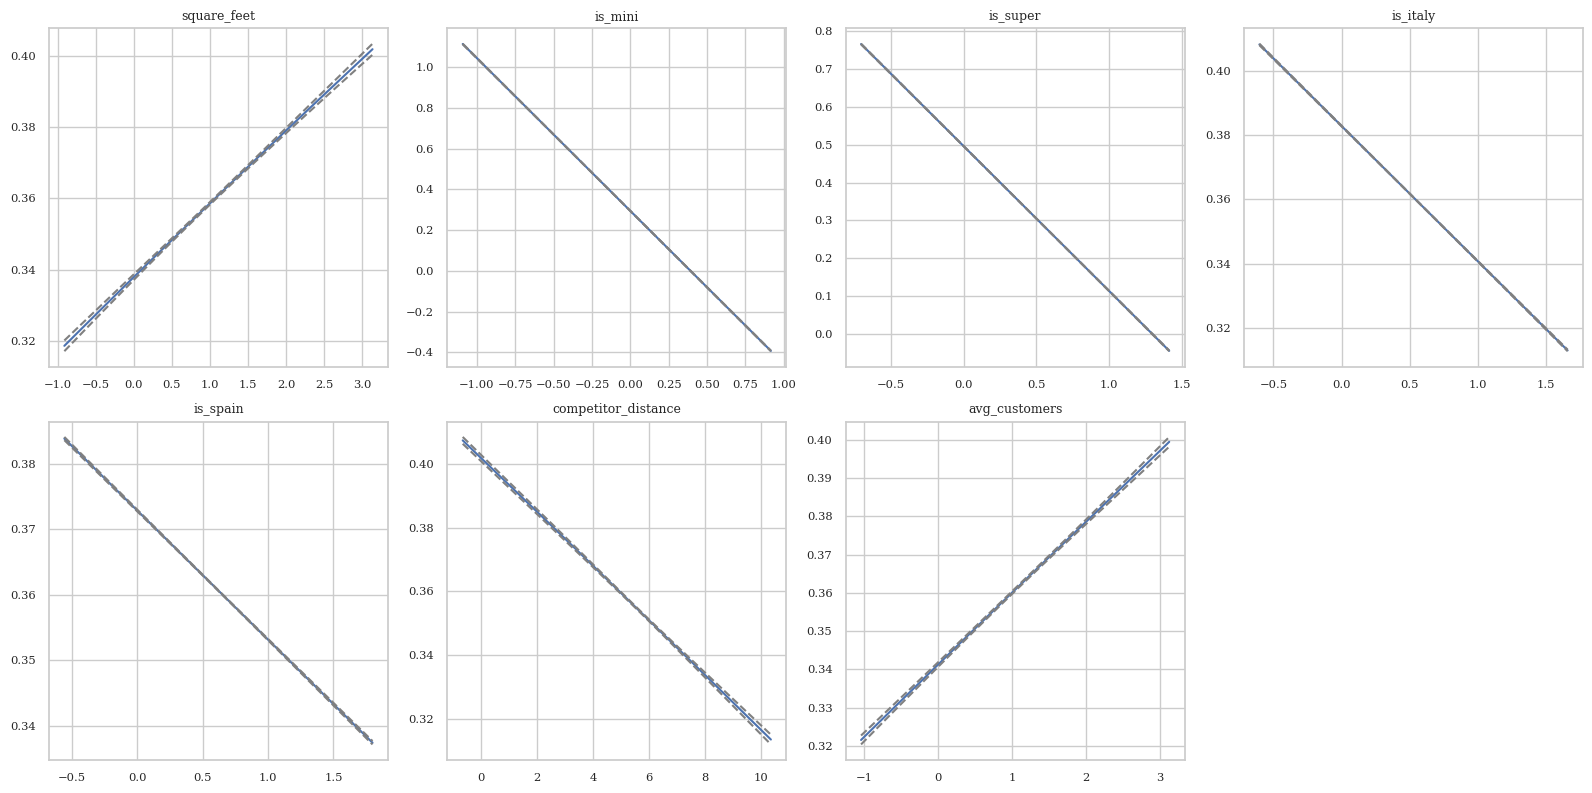

In [148]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (16, 8))
index = 0
ax = ax.flatten()
for col_name in list(X.columns):
	XX = gam.generate_X_grid(term = index)
	sns.lineplot(x = XX[:, index], y = gam.partial_dependence(term = index, X = XX), ax = ax[index])
	sns.lineplot(x = XX[:, index], y = gam.partial_dependence(term = index, X = XX, width = .95)[1][:, 0], color = "gray", ls = "--", ax = ax[index])
	sns.lineplot(x = XX[:, index], y = gam.partial_dependence(term = index, X = XX, width = .95)[1][:, 1], color = "gray", ls = "--", ax = ax[index])
	ax[index].set_title(col_name)
	index = index + 1
ax[-1].axis("off")
plt.tight_layout()


## decision tree (with pruning)

In [151]:
# initialize MSE and lambda
best_alpha = {
	"MSE": float("inf"),
	"alpha": float("inf")
}

# fit a decision tree with all data to derive the alpha values (for tree pruning)
tree = DecisionTreeRegressor(random_state = 0)
tree.fit(X_scaled, y)

# different values of alpha
alphas = []
for node in tree.cost_complexity_pruning_path(X_scaled, y).impurities:
	alphas.append(max(0, node))
print(alphas)

for alpha in alphas:

	# initialize kfold object to use for model evaluation
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 0)
	
	# store mse
	mse_folds = 0

	# run k-fold cv
	for train_idx, validation_idx in kf.split(X_scaled):
		X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
		y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

		# fit
		pruned_tree = DecisionTreeRegressor(ccp_alpha = alpha, random_state = 0)
		pruned_tree.fit(X_train, y_train)

		# predict
		y_pred = pruned_tree.predict(X_validation)
		# conversion of y_validation to np.array
		y_validation = np.array([element for sublist in y_validation.values for element in sublist])
		mse_folds = mse_folds + np.mean((y_validation - y_pred) ** 2)

	# cross-validation MSE
	estimated_test_error = mse_folds / number_folds

	# check if the estimated_test_error has decreased
	if estimated_test_error < best_alpha["MSE"]:
		best_alpha["MSE"] = estimated_test_error
		best_alpha["alpha"] = alpha

model_name = "decision tree (with pruning, alpha = " + str(best_alpha["alpha"]) + ")"

cv_mse = pd.concat([cv_mse, pd.DataFrame([{"MSE": best_alpha["alpha"]}])])
cv_mse = cv_mse.rename(index = {0: model_name})

cv_mse

[1.023181539494544e-15, 1.5480357736426715e-14, 6.967108371706369e-14, 2.1327650756575166e-13, 3.6235784743136414e-13, 5.283595783112105e-13, 7.53819525319462e-13, 1.0814270960205856e-12, 1.652703455571706e-12, 2.6033338447935723e-12, 3.782190560741583e-12, 5.483362504795272e-12, 7.243784239108209e-12, 9.133827916230077e-12, 1.1064419898805986e-11, 1.3075881118614539e-11, 1.5200233368280656e-11, 1.747359116658724e-11, 1.9859044186887333e-11, 2.225698381153052e-11, 2.4875551692578788e-11, 2.815623171651775e-11, 3.150798496183901e-11, 3.528475644998253e-11, 3.910056041907714e-11, 4.297352991973943e-11, 4.709888420014371e-11, 5.1293663242783325e-11, 5.588700939066864e-11, 6.049047366711117e-11, 6.581317772239951e-11, 7.156520117253724e-11, 7.733859774816664e-11, 8.313645594171248e-11, 8.902712049045173e-11, 9.633218193509188e-11, 1.037269422946944e-10, 1.1167336803434106e-10, 1.204881527883117e-10, 1.2937281705186855e-10, 1.3834390225990012e-10, 1.4753273565778117e-10, 1.5693260972208612e

,MSE
best linear regression,0.0000057052
poly regression (order = 2),0.0000059900
poly regression (order = 3),0.0000129490
poly regression (order = 4),0.0003057598
regression spline (order = 1),0.0000037424
regression spline (order = 2),0.0000047465
regression spline (order = 3),0.0001244772
regression spline (order = 4),0.1692337696
gam (lambda = 1000),0.0000057255
"decision tree (with pruning, alpha = 3.513403324480653e-08)",0.0000000351


In [150]:
from sklearn.tree import export_text
from sklearn.tree import export_graphviz
import graphviz

final_tree = DecisionTreeRegressor(ccp_alpha = best_alpha["alpha"], random_state = 0)
final_tree.fit(X_scaled, y)

# Visualize the tree structure as text
tree_rules = export_text(final_tree, feature_names = X_scaled.columns.tolist())
print("Decision Tree Rules:\n")
print(tree_rules)

# Visualize the tree as a graph
dot_data = export_graphviz(final_tree, out_file=None, 
	feature_names=X_scaled.columns.tolist(),
	filled=True, rounded=True,
	special_characters=True)

graph = graphviz.Source(dot_data)

Decision Tree Rules:

|--- avg_customers <= -0.33
|   |--- is_italy <= 0.53
|   |   |--- is_spain <= 0.62
|   |   |   |--- competitor_distance <= 1.51
|   |   |   |   |--- competitor_distance <= 0.47
|   |   |   |   |   |--- avg_customers <= -0.66
|   |   |   |   |   |   |--- avg_customers <= -0.89
|   |   |   |   |   |   |   |--- square_feet <= -0.85
|   |   |   |   |   |   |   |   |--- value: [9.42]
|   |   |   |   |   |   |   |--- square_feet >  -0.85
|   |   |   |   |   |   |   |   |--- square_feet <= -0.72
|   |   |   |   |   |   |   |   |   |--- value: [9.43]
|   |   |   |   |   |   |   |   |--- square_feet >  -0.72
|   |   |   |   |   |   |   |   |   |--- avg_customers <= -0.92
|   |   |   |   |   |   |   |   |   |   |--- value: [9.43]
|   |   |   |   |   |   |   |   |   |--- avg_customers >  -0.92
|   |   |   |   |   |   |   |   |   |   |--- value: [9.44]
|   |   |   |   |   |   |--- avg_customers >  -0.89
|   |   |   |   |   |   |   |--- square_feet <= -0.67
|   |   |   |   | 